In [350]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.misc import derivative
from tqdm.auto import tqdm

# Load in data

We can see from plotting the data that it looks roughly like a Lorentzian with peak 1.4 and width 0.0002, with $t_0$ (centre) = 0.00015

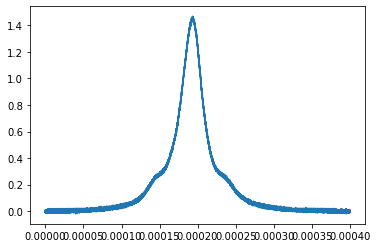

In [351]:
stuff = np.load('sidebands.npz')
t = stuff['time']
d = stuff['signal']

plt.plot(t,d)

# a) Model the data as a Lorentzian 

The following code is adapted from Jon's `newton.py`. We are fitting parameters a (`p[0]`), $t_0$ (`p[1]`), and w (`p[2]`).

The data is modeled as a Lorentzian: $y = \frac{a}{1+(t-t_0)^2/w^2}$, where $a$ = `p[0]`, $t_0$ = `p[1]`, and $w$ = `p[2]`

Here I use Newton's method, which allows us to linearize a model that is nonlinear in its parameters by calculating the model $A(m_0)$ and local gradient $A_m$, then solving the linear system $A_mN^{-1}A_m\delta m = A_m^TN^{-1}r$, where $r$ are the residuals, $(d-A(m))$.

We set $m = m + \delta m$ at each step and repeat until $\delta m$ is small. This usually only takes a few iterations, I use 50 here to make sure it's converged (and this runs really quickly so it doesn't matter too much if I use 5 or 50!)

In [352]:
def calc_lorentz(p,t):
    y=p[0]/(1+(((t-p[1])**2)/p[2]**2))
    
    grad=np.zeros([t.size,p.size])
    
    #now differentiate w.r.t. all the parameters
    grad[:,0] = 1.0/(1+((t-p[1])**2)/p[2]**2)
    grad[:,1] = (2*(t-p[1])/(t**2-2*p[1]*t+p[1]**2+p[2]**2))*y
    grad[:,2] = (2/p[2]-2*p[2]/(t**2-2*p[1]*t+p[1]**2+p[2]**2))*y 
    
    return y,grad

Best fit parameters are: a = 1.422810680632242, t0 = 0.0001923586493756531, and w = 1.792369079401261e-05


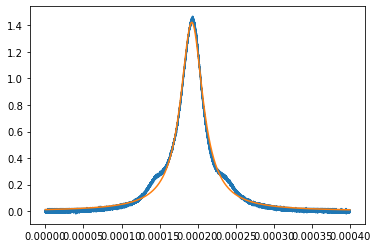

In [353]:
#starting guess
p0 = np.array([1.4,0.0002,0.0001])

p=p0.copy()
for j in range(50):
    pred,grad=calc_lorentz(p,t)
    r=d-pred
    err=np.sum(r**2)
    r=r.T
    #grad=np.matrix(grad)

    lhs=grad.T@grad
    rhs=grad.T@r
    dp=np.linalg.inv(lhs)@(rhs)
    for i in range(p.size):
        p[i]=p[i]+dp[i]
print(f"Best fit parameters are: a = {p[0]}, t0 = {p[1]}, and w = {p[2]}")
plt.plot(t,d)
plt.plot(t,pred)

# b) Estimate noise and error in parameters

$\chi^2$ (or error) is given by $(A^TN^{-1}A)^{-1}$, where in our case, $A = (A(m) - d) \equiv r \Rightarrow$ the estimated noise is just $\sum r^2$

Since it's hard to say if our noise is centered around zero and has some apparent structure, we'll use the RMS ($\sqrt{\sum r^2}$) of the residuals for our noise estimate.

The parameter errors are given by taking the square root of the covariance matrix with all the elements along the diagonal (`np.diag(cov)`), where the covariance matrix is the inverse of what we called `lhs` in the above code.

Chi^2 : 63.672662307173326
Noise in data is estimated to be 0.025233442552924347
Error in parameters: a = 0.016861712189248406, t_0 = 2.1235095259315283e-07, w = 3.007158943456581e-07


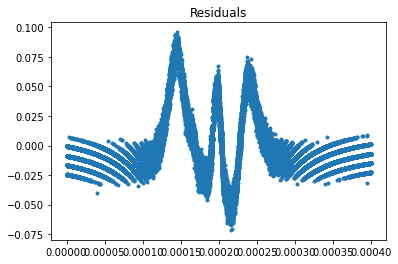

In [377]:
print(f'Chi^2 : {np.sum(r**2)}')
print(f'Noise in data is estimated to be {np.sqrt(np.sum(r**2)/len(r))}')
param_err = np.sqrt(np.diag(np.linalg.inv(lhs)))
print(f'Error in parameters: a = {param_err[0]}, t_0 = {param_err[1]}, w = {param_err[2]}')
plt.title('Residuals')
plt.plot(t,r,'.')

# c) Use numerical derivatives

I use scipy's `scipy.misc.deriv` for my numerical differentiator, alone with a wrapper I found here: https://stackoverflow.com/questions/20708038/scipy-misc-derivative-for-multiple-argument-function. This wrapper essentially just passes the values for the variables we aren't differentiating over to `scipy.misc.deriv`, which I used because it accepts arguments easily, and I wasn't able to figure out how to write my own differentiator to do so without wasting too much time. 

`scipy.misc.deriv` is a 3-point derivative, so we know that the optimal $\delta$ is $\sqrt{\varepsilon}$ (Lecture 1 ppt), where $\varepsilon$ is machine precision, so for double point precision, $\delta = \sqrt{10^{-16}}$,

In [355]:
def deriv(f,x):
    delta = (1e-16)**(1/5)
    return (1/(12*delta))*(f(x-2*delta)-8*f(x-delta)+8*f(x+delta)-f(x+2*delta))

def lorentzian(a,t0,w,t):
    #plt.plot(t,a/(1+(((t-t0)**2)/w**2)))
    return a/(1+(((t-t0)**2)/w**2))

def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(*args)
    return derivative(wraps, point[var], dx = np.sqrt(1e-16))

def lorentz_numerical(p,t):
    pred = lorentzian(*p,t)
    grad=np.zeros([len(t),len(p)])
    
    grad[:,0] = partial_derivative(lorentzian,var=0,point=[*p,t])
    grad[:,1] = partial_derivative(lorentzian,var=1,point=[*p,t])
    grad[:,2] = partial_derivative(lorentzian,var=2,point=[*p,t])
    
    return pred,grad

Best fit parameters are: a = 1.4228106682238026, t0 = 0.0001923586491808329, and w = 1.792369110682118e-05


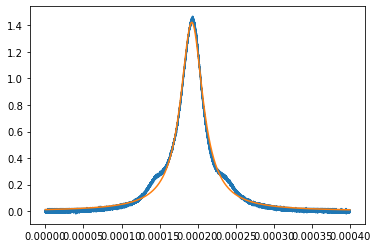

In [356]:
#starting guess
p0_num = [1.4,0.0002,0.0001]

p_num=p0_num.copy()
for j in range(10):
    pred_num,grad_num=lorentz_numerical(p_num,t)
    r_num=d-pred_num
    #if (np.abs(err - np.sum(r**2)) < 1e-16): break #exit when error < machine precision
    err_num=np.sum(r_num**2)
    r_num=r_num.T
    #grad=np.matrix(grad)

    lhs_num=grad_num.T@grad_num
    rhs_num=grad_num.T@r_num
    dp_num=np.linalg.inv(lhs_num)@(rhs_num)
    for i in range(len(p_num)):
        p_num[i]=p_num[i]+dp_num[i]
print(f"Best fit parameters are: a = {p_num[0]}, t0 = {p_num[1]}, and w = {p_num[2]}")
plt.plot(t,d)
plt.plot(t,pred_num)

Estimated noise is: 0.0252334425529793
Chi^2 = 63.67266230745065
Error in parameters: a = 0.016861711612780564, t_0 = 2.12351036014805e-07, w = 3.00715989438103e-07


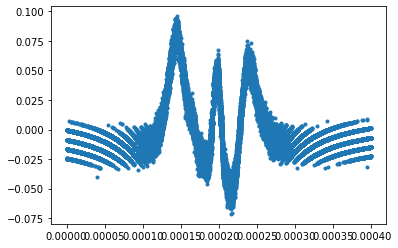

In [385]:
noise_num = np.sqrt(np.sum(r_num**2)/len(r_num))
print(f"Estimated noise is: {noise_num}")
print(f"Chi^2 = {np.sum(r_num**2)}")
param_err_num = np.sqrt(np.diag(np.linalg.inv(lhs_num)))
print(f'Error in parameters: a = {param_err_num[0]}, t_0 = {param_err_num[1]}, w = {param_err_num[2]}')
plt.plot(t,r_num,'.')

### Are the numerical and analytical derivative fits statistically different?

We can see that the differnce between the parameters fit by Newton's method with analytical derivaties and fit with numerical derivatives are all at least 6 orders of magnitude smaller than the uncertainties on the parameters fit by analytical derivatives, so there is statistically no difference between the two methods.

In [358]:
p_diff = p-p_num
print(f'Difference between analytical and numerical derivative model parameters {p_diff}')
print(f'Uncertainties on analytical derivative model parameters {param_err}')

Difference between analytical and numerical derivative model parameters [ 1.24084394e-08  1.94820207e-13 -3.12808569e-13]
Uncertainties on analytical derivative model parameters [1.68617122e-02 2.12350953e-07 3.00715894e-07]


# d) Model as the sum of 3 Lorentzians

Parameter array `p_3` now looks like `[a,t0,w,b,c,dt]`, where a, t0, and w come from the results of the above fit.

In [359]:
def lorentzian_3(a,t0,w,b,c,dt,t):
    #plt.plot(t,a/(1+(((t-t0)**2)/w**2)) + b/(1+(((t-t0+dt)**2)/w**2)) + c/(1+(((t-t0-dt)**2)/w**2)))
    return a/(1+(((t-t0)**2)/w**2)) + b/(1+(((t-t0+dt)**2)/w**2)) + c/(1+((((t-t0-dt)**2)/w**2)))

def lorentz_numerical_3(p,t):
    pred = lorentzian_3(*p,t)
    grad = np.zeros([len(t),len(p)])
    
    grad[:,0] = partial_derivative(lorentzian_3,var=0,point=[*p,t])
    grad[:,1] = partial_derivative(lorentzian_3,var=1,point=[*p,t])
    grad[:,2] = partial_derivative(lorentzian_3,var=2,point=[*p,t])
    grad[:,3] = partial_derivative(lorentzian_3,var=3,point=[*p,t])
    grad[:,4] = partial_derivative(lorentzian_3,var=4,point=[*p,t])
    grad[:,5] = partial_derivative(lorentzian_3,var=5,point=[*p,t])
    
    return pred,grad

Best fit parameters are: a = 1.4429923932750095, t0 = 0.00019257852173625134, w = 1.606510942360116e-05, b = 0.10391077999606547, c = 0.06473253001386294, dt = 4.456716295426202e-05


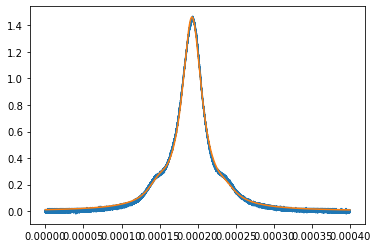

In [360]:
#starting guess
p0_3 = [1.4, 0.00019, 1.792e-5, 0.2, 0.2, 2e-5]
p_3=p0_3.copy()
for j in range(50):
    pred_3,grad_3=lorentz_numerical_3(p_3,t)
    r_3=d-pred_3
    err_3=np.sum(r_3**2)
    r_3=r_3.T

    lhs_3=grad_3.T@grad_3
    rhs_3=grad_3.T@r_3
    dp_3=np.linalg.inv(lhs_3)@(rhs_3)
    for i in range(len(p_3)):
        p_3[i]=p_3[i]+dp_3[i]
print(f"Best fit parameters are: a = {p_3[0]}, t0 = {p_3[1]}, w = {p_3[2]}, b = {p_3[3]}, c = {p_3[4]}, dt = {p_3[5]}")

plt.plot(t,d)
plt.plot(t,pred_3)

In [383]:
chi_3 = np.sum(r_3**2)
print(f"Chi^2 = {chi_3}")

noise_3 = np.sqrt(np.sum(r_3**2)/len(r_3))
print(f"Estimated noise is: {noise_3}")

param_err_3 = np.sqrt(np.diag(np.linalg.inv(lhs_3)))
print(f"Parameter uncertainties are:\n\
      a = {param_err_3[0]},\n\
      t0 = {param_err_3[1]}\n\
      w = {param_err_3[2]}\n\
      b = {param_err_3[3]}\n\
      c = {param_err_3[4]}\n\
      dt = {param_err_3[5]}\n")

Chi^2 = 21.247274184334692
Estimated noise is: 0.014576444760069135
Parameter uncertainties are:
      a = 0.018278031813332398,
      t0 = 2.1640415984078534e-07
      w = 3.8756145689578853e-07
      b = 0.0174333849558119
      c = 0.017070234824102536
      dt = 2.6087882033056806e-06



# e) Look at residuals and determine if error bars are to be believed

The residuals do not look like white noise and clearly have some structure, which means that there must be correlation between the parameters. This means that the error bars calculated above are not a complete description of the data, and we need to take correlation into account.

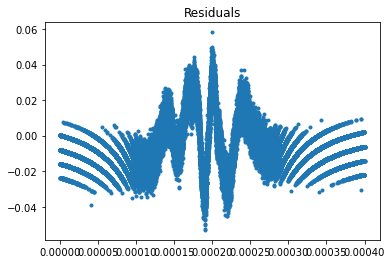

In [362]:
plt.title('Residuals')
plt.plot(t,r_3,'.')

# f) Generate some realizations for the parameter errors using the full covariance matrix $A^TN^{-1}A$ from d)

Up until now we've been assuming the noise is uncorrelated, so $N = \mathbb{I}$. Now we need to figure out what the correlation between parameters is, in order to get a better estimation of our parameter errors.

To do this, we'll plot the 3-peak Lorentzian for parameters offset from our best fit by a value picked from a Gaussian distribution of the full distribution of the parameter covariance matrix, $A^TN^{-1}A$. Note that the covariance matrix is just the inverse of `lhs` in our code above.

Over many realizations, $<dd^T>$, where $d$ is the correlated data, should converge to the noise matrix, $N$, which is unknown to us. This means that if we only work with correlated data, we can get a better estimate of $\chi^2$, since this will include $N$ in our covariance matrix. 

The correlated data, $d$, is generated by evaluating the model (3-peak Lorentzian) at offset parameters. This offset is obtained by sampling the collective set of parameters from the full distribution given by the parameter covariance matrix (this is done by `np.random.multivariate_normal(mean,cov)`, where `mean` is the best-fit parameters, and `cov` is the covariance matrix we got from our best-fit, assuming $N = \mathbb{I}$).

Here, I compute `n_real` = 100 realizations, compute $\chi^2$, and then average this over `n_real`.

I get $\chi^2_{random} > \chi^2_{best-fit}$. This doesn't make sense, because now we are taking into account the correlation between parameters (which is like calculating this with a noise matrix instead of the identity matrix), so we should, on average, get a better result for $\chi^2$ but even averaging over 100 realizations (I also tried 1000 and got the same result), we don't get any improvement over the best-fit $\chi^2$. 

Best-fit chi^2: 21.247274184334692
Average chi^2 of 100 realizations 27.970001867120505
Difference in chi^2 = -6.722727682785813


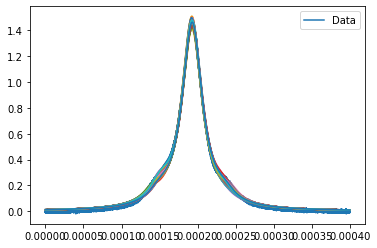

In [413]:
cov = np.linalg.inv(lhs_3)

n_real = 100

plt.plot(t,d,label='Data')

chi2 = np.array(())

shifted_params = np.random.multivariate_normal(p_3,cov,n_real)

for param in shifted_params:
    mod = lorentzian_3(*param,t)
    resid = d-mod
    chi2 = np.append(chi2,np.sum(resid**2))
    plt.legend()
    plt.plot(t,mod)
    
print(f"Best-fit chi^2: {chi_3}")    
print(f"Average chi^2 of {n_real} realizations {np.mean(chi2)}")
print(f"Difference in chi^2 = {chi_3 - np.mean(chi2)}")

# g) Repeat d) using an MCMC

The `mcmc` funtion is adapted from Jon's mcmc_class.py (from 2021 github). I use a helper function `lorentz_chisq`, that calculates $\chi^2$ by $\sum r^2$.

The function takes a step size of `np.random.multivariate_normal(np.zeros(len(pars)),cov)` (from above, but parameters are all set to 0 so we get the amount of parameter shift) to ensure that we are taking statistically relevant steps along the directions of parameter space that match the correlation between our parameters.

This should be multiplied by a scaling function to get shifts for each parameter. I played around with this a bit and found that a scale factor of 1 converged quickly and accurately.

My MCMC accepts 27.5% of events, so based on the rule of thumb that it should accept 25% of events, it seems that I am stopping at a reasonable number of steps.

In [250]:
def lorentz_chisq(pars,x,y):
    pred=lorentzian_3(*pars,x)
    return np.sum((y-pred)**2)

def mcmc(pars,x,y,cov,fun,scale,nstep):
    accept_num = 0
    chi_cur=fun(pars,x,y)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    for i in tqdm(range(nstep)):
        trial_pars=pars+scale*np.random.multivariate_normal(np.zeros(len(pars)),cov)
        trial_chisq=fun(trial_pars,x,y,)
        delta_chisq=trial_chisq-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            accept_num = accept_num + 1
            pars=trial_pars
            chi_cur=trial_chisq
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec,accept_num

In [251]:
x = t
y_true = d
nstep = 50000

chain2,chisq2,accept=mcmc(p0_3,t,d,cov,lorentz_chisq,scale=1,nstep=nstep)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [255]:
print(f"Accepted events: {accept/nstep * 100}%")

Accepted events: 27.52%


### Plot each parameter to see if the chain has converged

These plots all look like white noise, so we can assume the chain has converged. We can cut out the burn-in and only keep the part that looks converged. From here, the parameters can be calculated as the mean of their chains, and the uncertainty on each parameter is the standard deviation of each parameter chain.

We can safely say that each chain has completed the burn-in and converged to white noise after 20000 steps, so we'll crop our arrays from `[20000:]` for evaluating the parameters and their errors

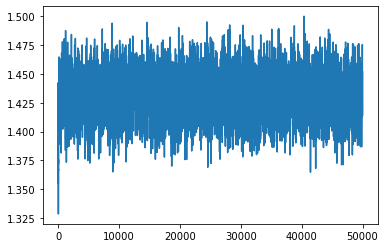

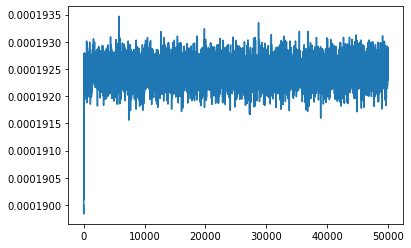

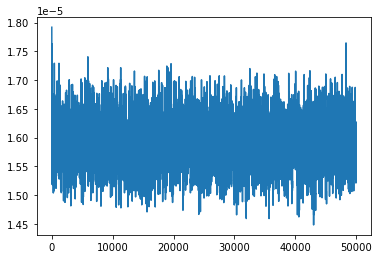

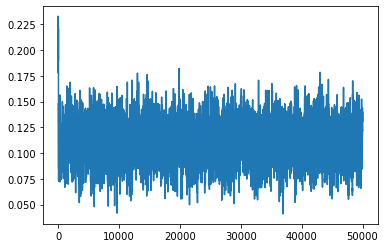

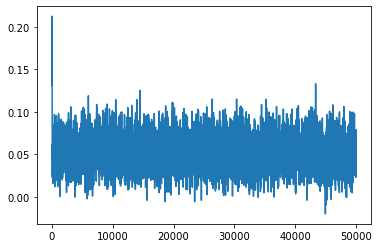

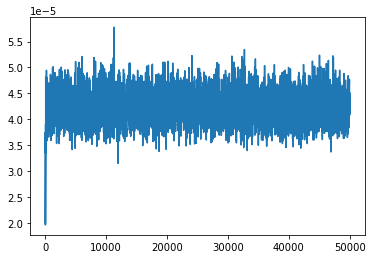

In [402]:
for column in chain2.T:
    plt.plot(column)
    plt.show()

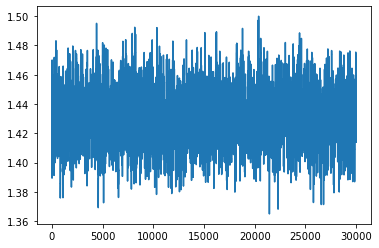

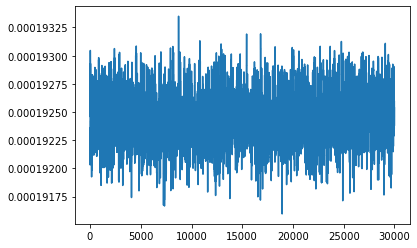

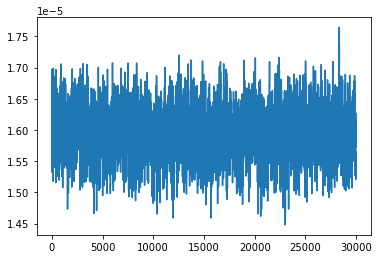

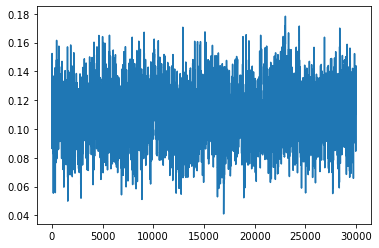

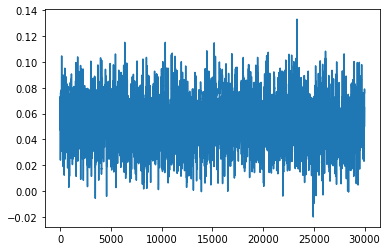

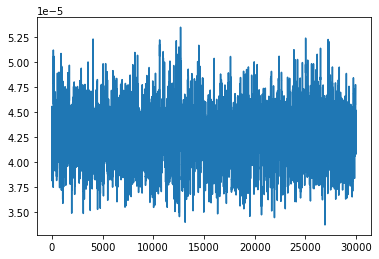

In [403]:
converged = chain2[20000:,:]

for column in converged.T:
    plt.plot(column)
    plt.show()

### Look at parameters and their error bars

We can see that the overall noise estimate decreases by several orders of magnitude compared to our Newton's method fits. 

However, the parameters and errors in the parameters stay roughly the same

In [404]:
a = np.mean(converged[:,0])
t0 = np.mean(converged[:,1])
w = np.mean(converged[:,2])
b = np.mean(converged[:,3])
c = np.mean(converged[:,4])
dx = np.mean(converged[:,5])

mcmc_params = [a,t0,w,b,c,dx]

print(f'Parameters from MCMC are:\n\
a = {np.mean(converged[:,0])}\n\
t0 = {np.mean(converged[:,1])}\n\
w = {np.mean(converged[:,2])}\n\
b = {np.mean(converged[:,3])}\n\
c = {np.mean(converged[:,4])}\n\
dx = {np.mean(converged[:,5])}')

Parameters from MCMC are:
a = 1.4314502801486813
t0 = 0.000192449868049886
w = 1.5940346557459447e-05
b = 0.11008700277812004
c = 0.05225978990574879
dx = 4.258264794472378e-05


In [405]:
print(f'Parameter Errors from MCMC are:\n\
Δa = {np.std(converged[:,0])}\n\
Δt0 = {np.std(converged[:,1])}\n\
Δw = {np.std(converged[:,2])}\n\
Δb = {np.std(converged[:,3])}\n\
Δc = {np.std(converged[:,4])}\n\
Δdx = {np.std(converged[:,5])}')
print("\n")
print(f'Difference in parameter errors compared to Newton\'s method::\n\
a = {param_err_3[0] - np.std(converged[:,0])}\n\
t0 = {param_err_3[1] -np.std(converged[:,1])}\n\
w = {param_err_3[2] -np.std(converged[:,2])}\n\
b = {param_err_3[3] -np.std(converged[:,3])}\n\
c = {param_err_3[4] -np.std(converged[:,4])}\n\
dx = {param_err_3[5] -np.std(converged[:,5])}')

Parameter Errors from MCMC are:
Δa = 0.018181944297012365
Δt0 = 2.2128484250698643e-07
Δw = 4.0252123054867363e-07
Δb = 0.01843719132842037
Δc = 0.01802887910932404
Δdx = 2.6972209672020797e-06


Difference in parameter errors compared to Newton's method::
a = 9.608751632003351e-05
t0 = -4.880682666201088e-09
w = -1.49597736528851e-08
b = -0.0010038063726084678
c = -0.0009586442852215042
dx = -8.843276389639911e-08


In [406]:
pred_mcmc = lorentzian_3(*mcmc_params,t)
r_mcmc = d-pred_mcmc
err_mcmc =np.sum(r_mcmc**2)
print(f'Noise in MCMC fit is: {np.sqrt(np.sum(r_mcmc**2)/len(r_mcmc))}')

Noise in MCMC fit is: 0.016082682352244814


Text(0.5, 1.0, 'MCMC Residuals')

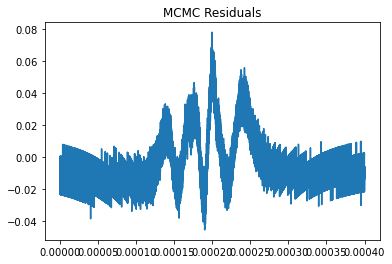

In [408]:
plt.plot(t,r_mcmc)
plt.title('MCMC Residuals')

# h) Since $dx$ $\rightarrow$ 9 GHz, what is the width of the cavity resonance, $w$, in GHz?

Using the output from the MCMC, we can apply the following formula to get the width of cavity resonance:

$w_{res} = w_{MCMC} \times \frac{dx_{actual}}{dx_{MCMC}}$, where both $dx$ values should be expressed in units of time (seconds):

$9$ GHz = $1.1 \times 10^{-10}$ s

To calculate the error, we can use the standard deviation: 
$\Delta w_{res} = w_{res} \sqrt{(\frac{\Delta w}{w})^2 + (\frac{\Delta dx}{dx})^2}$

The error seems a little large (I'd expect it to be at least an OOM smaller than the width, since the uncertainties are pretty small), but I can't figure out what's going on.

In [411]:
actual_dx = 1/(9e9)
mcmc_dx = dx

mcmc_w = w

ratio = mcmc_dx/actual_dx

actual_w = mcmc_w/ratio
err_w = actual_w * np.sqrt((np.std(converged[:,2])/mcmc_w)**2 + (np.std(converged[:,5])/mcmc_dx)**2)

print(f'Width of cavity resonance = {1/actual_w/1e9} +/- {1/err_w/1e9} GHz')

Width of cavity resonance = 24.04237763094123 +/- 352.5854356727813 GHz
